## MNIST with CNN

#### I start with the mnist fashion dataset from TensorFlow official website and modify it to mnist dataset. The code is mostly the same with FCNN part. Different from that code, we have additional layers in CNN for feature extraction step.

* In this section, different from traditional methods we also trained feature extraction part. 
* This is doing by the convolution operation. relationship between the image pixels can not grasp with FCNN. 
* So, feature extraction step is done by convolution part for a given dataset. 
* Classification part is done by FCNN. 
* Different from the FCNN, CNN has convolutional layers.
* In fact each convolutional layer is composed of filter. Assume that we have an image some filter can learn edges, some corners.. This is done by automatically in CNN

In [1]:
import tensorflow as tf

In [2]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Import the dataset

In [4]:
dataset, metadata = tfds.load('mnist', as_supervised=True, with_info=True) #modify as mnist
train_dataset, test_dataset = dataset['train'], dataset['test']

Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

In [5]:
class_names = ['0', '1' , '2', '3', '4', '5',
               '6', '7', '8', '9',]                 #dont need it but just want to add class names 

### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [6]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`.


The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

In [7]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

### Explore the processed data

Let's plot an image to see what it looks like.

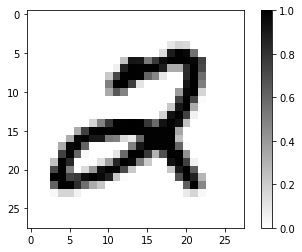

In [8]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

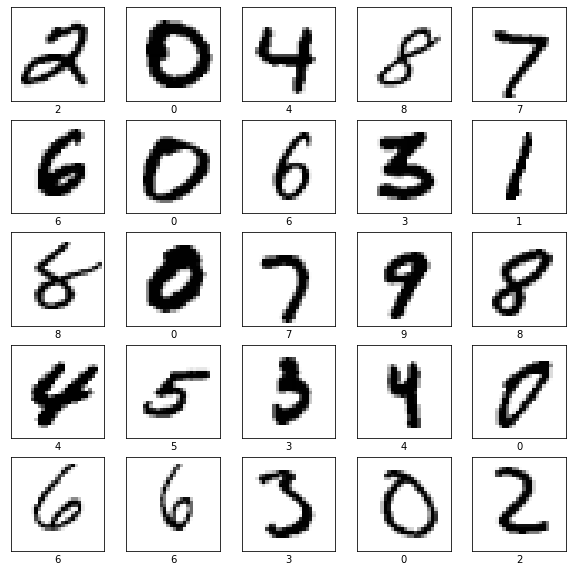

In [9]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

* In the 1st convolutional layer  I have 32 seperate filters each filter has size 3x3.   
* Learns 9 parameters per filter.
 * In the second convolutional layer applying same operation with 64 filters 
* Padding=same means that my output image size will be the same of the input image size.

* The last layer is a 10 node softmax layer, giving probability of each class.
 * Softmax adjusts probabilities so that they total 1.

Here's the complete architecture of our model:

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

The network summary shows that (7, 7, 64) outputs were flattened into vectors of shape (3136) before going through two Dense layers.

This network layers are:






### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* *Optimizer* This is how the model is updated based on the data it sees and its loss function.
* *Metrics* Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

In [13]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [14]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 28s 14ms/step - loss: 0.1172 - accuracy: 0.9642
Epoch 2/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0397 - accuracy: 0.9875
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0266 - accuracy: 0.9915
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0191 - accuracy: 0.9938
Epoch 5/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0151 - accuracy: 0.9952
Epoch 6/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0110 - accuracy: 0.9960
Epoch 7/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0094 - accuracy: 0.9970
Epoch 8/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0076 - accuracy: 0.9976
Epoch 9/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0070 - accuracy: 0.9977
Epoch 10/10
1875/1875 [==============================] - 26s 14m

As the model trains, the loss and accuracy metrics are displayed and reached %99.82

## Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 0.0381 - accuracy: 0.9912
Accuracy on test dataset: 0.9911999702453613


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset (training dataset accuracy: 0.9982 as we can see the above result). This is completely normal, since the model was trained on the `train_dataset`. When the model sees images it has never seen during training, (that is, from the `test_dataset`), we can expect performance to go down. 

## Make predictions and explore

With the model trained, we can use it to make predictions about some images.

In [16]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [17]:
predictions.shape

(32, 10)

Here, the model has predicted the probability of each label for each image in the testing set. Let's take a look at the first prediction:

In [18]:
predictions[0]

array([9.8901091e-21, 7.1662679e-19, 1.0000000e+00, 3.7550833e-19,
       3.3589211e-16, 2.0266280e-26, 1.0297433e-20, 1.1149971e-16,
       4.2981257e-12, 7.5844888e-20], dtype=float32)

A prediction is an array of 10 numbers. We can see which label has the highest confidence value:

In [19]:
np.argmax(predictions[0])

2

So the model is usually most confident that this image is a 2. Let's check the label:

In [20]:
test_labels[0]

2

We can graph this to look at the full set of 10 class predictions

In [21]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array. 

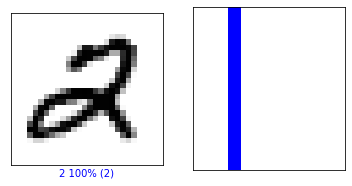

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

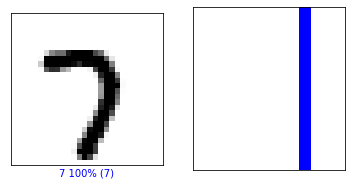

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

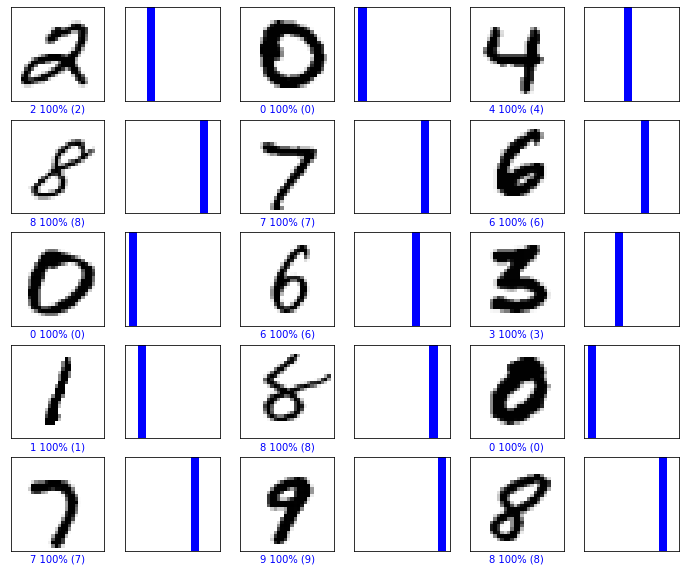

In [24]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Finally, use the trained model to make a prediction about a single image. 

In [25]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [26]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Now predict the image:

In [27]:
predictions_single = model.predict(img)

print(predictions_single)

[[9.8901091e-21 7.1662405e-19 1.0000000e+00 3.7550833e-19 3.3589081e-16
  2.0266202e-26 1.0297433e-20 1.1150013e-16 4.2981014e-12 7.5844888e-20]]


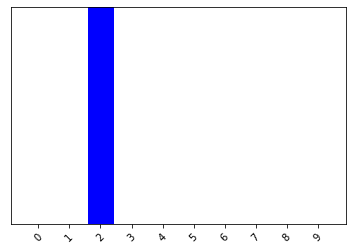

In [28]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [29]:
np.argmax(predictions_single[0])

2

And, as before, the model predicts a label of 2.